**Libraries Used**

In [14]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns

**Loading Dataset**

In [15]:
df = pd.read_csv("car_prices.csv")

**Cleaning Data**

In [16]:
df = df.drop(columns = ["saledate", "vin", "color", "interior"])
df = df.dropna(subset=['year', 'make', 'model', 'trim', 'body', 'transmission', 'state', 'condition', 'odometer', 'seller', 'mmr', 'sellingprice'])

categorical_cols = [
    'make','model','trim','body','transmission','state','condition','seller'
]

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472869 entries, 0 to 558836
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          472869 non-null  int64  
 1   make          472869 non-null  int64  
 2   model         472869 non-null  int64  
 3   trim          472869 non-null  int64  
 4   body          472869 non-null  int64  
 5   transmission  472869 non-null  int64  
 6   state         472869 non-null  int64  
 7   condition     472869 non-null  int64  
 8   odometer      472869 non-null  float64
 9   seller        472869 non-null  int64  
 10  mmr           472869 non-null  float64
 11  sellingprice  472869 non-null  float64
dtypes: float64(3), int64(9)
memory usage: 46.9 MB


In [18]:
X = df[['year', 'make', 'model', 'transmission']]
y = df['sellingprice']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

**Decision Tree Regression Implementation**

In [19]:
model1 = DecisionTreeRegressor()
model1.fit(X_train, y_train)

pred_dec = model1.predict(X_test)

MSE = mean_squared_error(y_test, pred_dec)

print("Test R²:", r2_score(y_test, pred_dec))
print("Test MAE:", mean_absolute_error(y_test, pred_dec))
print(MSE/y_test.var())

Test R²: 0.8949251102543712
Test MAE: 2063.577492980162
0.1050737787120494


**Linear Regression Implementation**

In [20]:
model2 = LinearRegression()
model2.fit(X_train, y_train)

pred_lin = model2.predict(X_test)

MSE = mean_squared_error(y_test, pred_lin)

print("Test R²:", r2_score(y_test, pred_lin))
print("Test MAE:", mean_absolute_error(y_test, pred_lin))
print(MSE/y_test.var())

Test R²: 0.34329446945593345
Test MAE: 5444.583300864372
0.6566985867166876


**Accuracy Visualization**

In [21]:
def visual(y_test, pred):
    df_plot = pd.DataFrame({
        'Actual': y_test,
        'Predicted': pred
    })

    plt.figure(figsize=(8,6))
    sns.scatterplot(x='Actual', y='Predicted', data=df_plot, alpha=0.6)
    sns.lineplot(x='Actual', y='Actual', data=df_plot, color='green')
    plt.title('Estimation Plot')
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.show()

**Decision Tree Regressor Visualization**

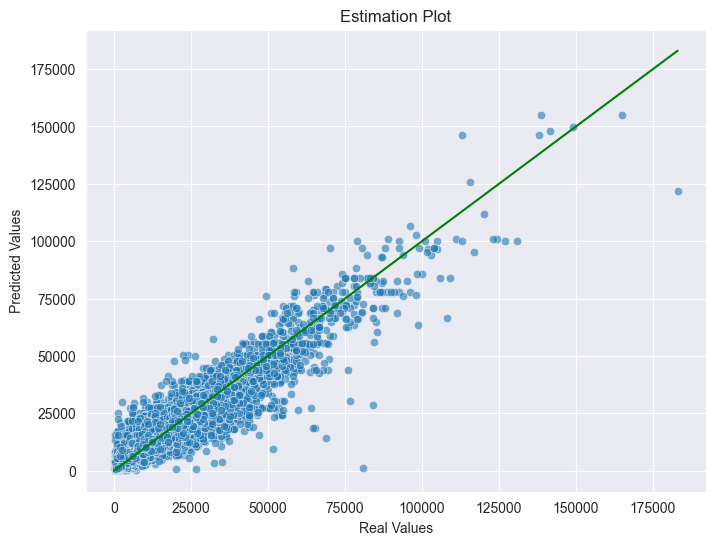

In [22]:
visual(y_test, pred_dec)

**Linear Regression Visualization**

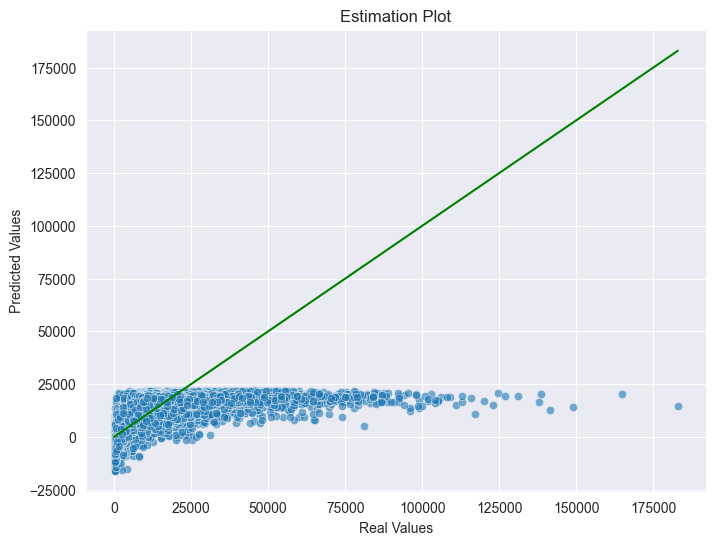

In [23]:
visual(y_test, pred_lin)

**GUI**

In [25]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd

class AutocompleteCombobox(ttk.Combobox):
    def set_completion_list(self, completion_list):
        self._completion_list = sorted(completion_list, key=str.lower)
        self['values'] = self._completion_list
        self._hits = []
        self.position = 0
        self.bind('<KeyRelease>', self._handle_keyrelease)

    def _autocomplete(self, delta=0):
        if delta:
            self.delete(self.position, tk.END)
        else:
            self.position = len(self.get())

        _hits = [item for item in self._completion_list if item.lower().startswith(self.get().lower())]
        if _hits != self._hits:
            self._hits = _hits
            if _hits:
                self['values'] = _hits
            else:
                self['values'] = self._completion_list

    def _handle_keyrelease(self, event):
        if event.keysym == "BackSpace":
            self.position = self.index(tk.END)
        self._autocomplete()

makes = list(label_encoders['make'].classes_)
models = list(label_encoders['model'].classes_)
transmissions = list(label_encoders['transmission'].classes_)

def predict_price():
    try:
        year_str = year_entry.get()
        if not year_str.isdigit() or not (1900 <= int(year_str) <= 2025):
            raise ValueError("Year must be between 1900 and 2025")

        year = int(year_str)
        make = make_combo.get()
        model_name = model_combo.get()
        transmission = transmission_combo.get()

        make_encoded = label_encoders['make'].transform([make])[0]
        model_encoded = label_encoders['model'].transform([model_name])[0]
        transmission_encoded = label_encoders['transmission'].transform([transmission])[0]

        input_df = pd.DataFrame([{
            'year': year,
            'make': make_encoded,
            'model': model_encoded,
            'transmission': transmission_encoded
        }])

        price_decision_tree = model1.predict(input_df)[0]
        price_linear = model2.predict(input_df)[0]

        result_label.config(
            text=f"Decision Tree Estimate: ${price_decision_tree:,.2f}\n"
                 f"Linear Regression Estimate: ${price_linear:,.2f}"
        )

    except ValueError as e:
        messagebox.showerror("Input Error", f"Please enter a valid year.\n{e}")

root = tk.Tk()
root.title("Car Price Predictor")
root.geometry("420x350")

tk.Label(root, text="Year").pack()
year_entry = tk.Entry(root)
year_entry.pack()

tk.Label(root, text="Make").pack()
make_combo = AutocompleteCombobox(root)
make_combo.set_completion_list(makes)
make_combo.pack()

tk.Label(root, text="Model").pack()
model_combo = AutocompleteCombobox(root)
model_combo.set_completion_list(models)
model_combo.pack()

tk.Label(root, text="Transmission").pack()
transmission_combo = AutocompleteCombobox(root)
transmission_combo.set_completion_list(transmissions)
transmission_combo.pack()

tk.Button(
    root,
    text="Predict Price",
    command=predict_price
).pack(pady=15)

result_label = tk.Label(root, text="", font=("Arial", 12, "bold"))
result_label.pack()

root.mainloop()
